### Duck Detection With Detectron2

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
# 일반적인 라이브러리 임포트
import numpy as np
import pandas as pd
import os, json, cv2, random
from os.path import join
from glob import glob
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# import some common detectron2 utilities
# 일반적인 detectron 유틸리티 임포트
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(20,20))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

##### Sort csv file

In [3]:
# csv 파일 읽어서 ndarrray로 저장 (image,xmin,ymin,xmax,ymax)
x=pd.read_csv('dataset/Duck-farm-604-export.csv',usecols=['image','xmin','ymin','xmax','ymax','label']).values

# ndarray를 'image'의 숫자를 기준으로 정렬 (데이터 프레임으로 변경 후 정렬)
x_df=pd.DataFrame(x)
x_df.columns=['image','xmin','ymin','xmax','ymax','label'] 
x_df=x_df.sort_values(by=['image'],axis=0)
# 다시 ndarray로 변경
x=x_df.to_numpy()
print(x)
print(len(x))

[['20_1_0.png' 893.7444933920706 480.871409921671 1045.991189427313
  805.1533942558747 'duck']
 ['20_1_0.png' 1051.6299559471363 528.8087467362924 1240.5286343612331
  830.5319843342036 'duck']
 ['20_1_0.png' 1574.6255506607931 548.5476501305483 1857.9735682819385
  874.2395561357703 'duck']
 ...
 ['40_2_932.png' 562.9030821545325 266.8635007005391 781.9093802650993
  758.5052917453152 'duck']
 ['40_2_932.png' 1003.7949553550358 242.37791039911264 1280.5759210653227
  905.9599999513516 'duck']
 ['40_2_932.png' 1233.0791788856309 273.90391791044783 1722.9325513196486
  1080.0 'duck']]
4510


##### Return Name (dataset/image/20_1_0.png -> 20_1_0.png)

In [4]:
def name(item):
    return os.path.basename(item)

##### Make image_list 

In [5]:
# 이미지 파일명을 리스트로 저장
image_list = glob("dataset/image/*.png")

# 리스트 정렬
image_list.sort()

# 이미지 파일 개수 세기
print(len(image_list))

# 정렬된 이미지 파일명과 어노테이션 파일(csv)의 데이터('image')가 일치하는지 확인
print(name(image_list[0]),x[0][0],sep='\n') 

603
20_1_0.png
20_1_0.png


##### Check Bounding Box

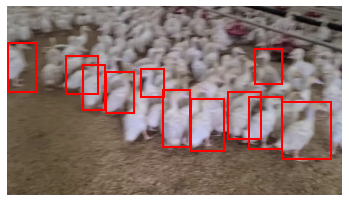

In [6]:
test_image = image_list[0]

# bounding box check
image = plt.imread(test_image)
for item in x:
    if(item[0] != name(test_image)):
        break
    xmin = float(item[1])
    ymin = float(item[2])
    xmax = float(item[3])
    ymax = float(item[4])
    width = xmax - xmin
    height = ymax - ymin
    ax = plt.gca()
    plt.imshow(image)
    rect = patches.Rectangle(
            (xmin, ymin), width, height, linewidth=2, edgecolor='red', fill=False
        )
    ax.add_patch(rect)
    plt.axis('off')

##### annotation file(csv) and image/.png -> COCO JSON

In [7]:
# 라벨 파싱을 처리한 개수를 나타내는 변수 
global num1
num1=0 
# parse_label 호출 횟수
global num2
num2=0


# coco json으로 만들기 위한 label 파싱 (id,image_id,category_id,bbox)
def parse_label(image_path, id, _annot_id):
    global num1,num2
    annot_id = _annot_id
    list_annot = []

    print(image_path)

    while(num1 < len(x)):
        item=x[num1]
        # annotation file(csv) 'image'와 name(image_path)가 같은지 확인
        if(item[0] != name(image_path)):
            break
        print(num1,item[0],image_path)

        class_=0
        if(item[5]=='dead'):
            class_=1
        elif(item[5]=='slapped'):
            class_=2

        xmin = float(item[1])
        ymin = float(item[2])
        xmax = float(item[3])
        ymax = float(item[4])
        width = float(xmax - xmin)
        height = float(ymax - ymin)
        
        annotation = dict()
        annotation["id"] = int(annot_id) # 각 오브젝트에 대한 아이디
        annotation["image_id"] = int(id) # 영상 아이디
        annotation["category_id"] = int(class_)
        annotation["bbox"] = [xmin, ymin, width, height]
        annotation["iscrowd"]=0 # 여러 개이거나 뭉쳐 있는 경우 1, 그런 데이터 거의 없으니 일단 0으로 통일 
        annotation["area"]=100.0 # segmentation mask에서 픽셀의 수, segmentatoin에서 쓰이지만 detection에서 안 쓰면 evaluate error가 발생하므로 그냥 추가했음 
        list_annot.append(annotation)
        annot_id += 1
        num1+=1
        if(num1 == len(x)):
            print('end')
            
    # 파싱한 것(딕셔너리), 개수 반환
    num2+=1
    print(num2,len(list_annot),annot_id)
    return list_annot, annot_id

In [8]:
# coco json으로 만들기 위한 영상 파싱 (id,width,height,file_name)
def parse_image(image_path, id):
    _image = Image.open(image_path)
    width, height = _image.size
    file_name = name(image_path)
    
    image = dict()
    image["id"] = id
    image["width"] = int(width)
    image["height"] = int(height)
    image["file_name"] = file_name
    _image.close()

    # 파싱한 것(딕셔너리) 반환
    return image

In [9]:
# 카테고리 정보 생성
categories = [
    {
        "id" : 0,
        "name" : "duck"
    },
    {
        "id" : 1,
        "name" : "dead"
    },
    {
        "id" : 2,
        "name" : "slapped"
    }
]

print(categories)

[{'id': 0, 'name': 'duck'}, {'id': 1, 'name': 'dead'}, {'id': 2, 'name': 'slapped'}]


In [10]:
# 학습 데이터에 대한 coco json 만들기

# 파싱한 것 가져오기
images = []
annotations = []
annot_id = 0
for id, image_path in tqdm(enumerate(image_list[:-10])): # tqdm: 진행률 프로그레스 바
     # 이미지 파싱한 것 저장
    images.append(parse_image(image_path, id))
    # 라벨 파싱한 것 저장
    parsed_annotations, annot_id = parse_label(image_path, id, annot_id)
    for annotation in parsed_annotations:
        annotations.append(annotation)

# labels_train.json 생성
coco_format = dict()
coco_format["info"] = "duck train dataset"
coco_format["images"] = images
coco_format["annotations"] = annotations
coco_format["licenses"] = "..."
coco_format["categories"] = categories
with open("dataset/labels_train.json", "w") as f:
    json.dump(coco_format, f)

75it [00:00, 738.04it/s]

dataset/image/20_1_0.png
0 20_1_0.png dataset/image/20_1_0.png
1 20_1_0.png dataset/image/20_1_0.png
2 20_1_0.png dataset/image/20_1_0.png
3 20_1_0.png dataset/image/20_1_0.png
4 20_1_0.png dataset/image/20_1_0.png
5 20_1_0.png dataset/image/20_1_0.png
6 20_1_0.png dataset/image/20_1_0.png
7 20_1_0.png dataset/image/20_1_0.png
8 20_1_0.png dataset/image/20_1_0.png
9 20_1_0.png dataset/image/20_1_0.png
10 20_1_0.png dataset/image/20_1_0.png
1 11 11
dataset/image/20_1_1024.png
11 20_1_1024.png dataset/image/20_1_1024.png
12 20_1_1024.png dataset/image/20_1_1024.png
13 20_1_1024.png dataset/image/20_1_1024.png
14 20_1_1024.png dataset/image/20_1_1024.png
15 20_1_1024.png dataset/image/20_1_1024.png
16 20_1_1024.png dataset/image/20_1_1024.png
17 20_1_1024.png dataset/image/20_1_1024.png
18 20_1_1024.png dataset/image/20_1_1024.png
19 20_1_1024.png dataset/image/20_1_1024.png
20 20_1_1024.png dataset/image/20_1_1024.png
21 20_1_1024.png dataset/image/20_1_1024.png
22 20_1_1024.png dataset/

263it [00:00, 899.87it/s]

dataset/image/24_0_252.png
1464 24_0_252.png dataset/image/24_0_252.png
1465 24_0_252.png dataset/image/24_0_252.png
1466 24_0_252.png dataset/image/24_0_252.png
1467 24_0_252.png dataset/image/24_0_252.png
1468 24_0_252.png dataset/image/24_0_252.png
1469 24_0_252.png dataset/image/24_0_252.png
1470 24_0_252.png dataset/image/24_0_252.png
1471 24_0_252.png dataset/image/24_0_252.png
161 8 1472
dataset/image/24_0_2521.png
1472 24_0_2521.png dataset/image/24_0_2521.png
1473 24_0_2521.png dataset/image/24_0_2521.png
1474 24_0_2521.png dataset/image/24_0_2521.png
1475 24_0_2521.png dataset/image/24_0_2521.png
1476 24_0_2521.png dataset/image/24_0_2521.png
1477 24_0_2521.png dataset/image/24_0_2521.png
1478 24_0_2521.png dataset/image/24_0_2521.png
162 7 1479
dataset/image/24_0_2549.png
1479 24_0_2549.png dataset/image/24_0_2549.png
1480 24_0_2549.png dataset/image/24_0_2549.png
1481 24_0_2549.png dataset/image/24_0_2549.png
1482 24_0_2549.png dataset/image/24_0_2549.png
1483 24_0_2549.png

457it [00:00, 905.83it/s]

dataset/image/32_1_70.png
2952 32_1_70.png dataset/image/32_1_70.png
2953 32_1_70.png dataset/image/32_1_70.png
2954 32_1_70.png dataset/image/32_1_70.png
2955 32_1_70.png dataset/image/32_1_70.png
2956 32_1_70.png dataset/image/32_1_70.png
2957 32_1_70.png dataset/image/32_1_70.png
362 6 2958
dataset/image/32_1_701.png
2958 32_1_701.png dataset/image/32_1_701.png
2959 32_1_701.png dataset/image/32_1_701.png
2960 32_1_701.png dataset/image/32_1_701.png
2961 32_1_701.png dataset/image/32_1_701.png
2962 32_1_701.png dataset/image/32_1_701.png
2963 32_1_701.png dataset/image/32_1_701.png
2964 32_1_701.png dataset/image/32_1_701.png
2965 32_1_701.png dataset/image/32_1_701.png
2966 32_1_701.png dataset/image/32_1_701.png
2967 32_1_701.png dataset/image/32_1_701.png
363 10 2968
dataset/image/32_1_771.png
2968 32_1_771.png dataset/image/32_1_771.png
2969 32_1_771.png dataset/image/32_1_771.png
2970 32_1_771.png dataset/image/32_1_771.png
2971 32_1_771.png dataset/image/32_1_771.png
2972 32_1

593it [00:00, 934.91it/s]

dataset/image/40_1_226.png
4264 40_1_226.png dataset/image/40_1_226.png
4265 40_1_226.png dataset/image/40_1_226.png
4266 40_1_226.png dataset/image/40_1_226.png
4267 40_1_226.png dataset/image/40_1_226.png
4268 40_1_226.png dataset/image/40_1_226.png
4269 40_1_226.png dataset/image/40_1_226.png
554 6 4270
dataset/image/40_1_2266.png
4270 40_1_2266.png dataset/image/40_1_2266.png
4271 40_1_2266.png dataset/image/40_1_2266.png
4272 40_1_2266.png dataset/image/40_1_2266.png
4273 40_1_2266.png dataset/image/40_1_2266.png
555 4 4274
dataset/image/40_1_2342.png
4274 40_1_2342.png dataset/image/40_1_2342.png
4275 40_1_2342.png dataset/image/40_1_2342.png
4276 40_1_2342.png dataset/image/40_1_2342.png
4277 40_1_2342.png dataset/image/40_1_2342.png
4278 40_1_2342.png dataset/image/40_1_2342.png
4279 40_1_2342.png dataset/image/40_1_2342.png
4280 40_1_2342.png dataset/image/40_1_2342.png
4281 40_1_2342.png dataset/image/40_1_2342.png
556 8 4282
dataset/image/40_1_2417.png
4282 40_1_2417.png dat

In [11]:
print(annot_id,len(annotations),len(images))

4457 4457 593


In [12]:
# 테스트 데이터에 대한 coco json 만들기

# 파싱한 것 가져오기
images = []
annotations = []
annot_id = 0
for id, image_path in tqdm(enumerate(image_list[-10:])): # tqdm: 진행률 프로그레스 바
     # 이미지 파싱한 것 저장
    images.append(parse_image(image_path, id))
    # 라벨 파싱한 것 저장
    parsed_annotations, annot_id = parse_label(image_path, id, annot_id)
    for annotation in parsed_annotations:
        annotations.append(annotation)

# labels_train.json 생성
coco_format = dict()
coco_format["info"] = "duck test dataset"
coco_format["images"] = images
coco_format["annotations"] = annotations
coco_format["licenses"] = "..."
coco_format["categories"] = categories
with open("dataset/labels_test.json", "w") as f:
    json.dump(coco_format, f)

10it [00:00, 767.81it/s]

dataset/image/40_2_310.png
4457 40_2_310.png dataset/image/40_2_310.png
4458 40_2_310.png dataset/image/40_2_310.png
4459 40_2_310.png dataset/image/40_2_310.png
4460 40_2_310.png dataset/image/40_2_310.png
4461 40_2_310.png dataset/image/40_2_310.png
594 5 5
dataset/image/40_2_388.png
4462 40_2_388.png dataset/image/40_2_388.png
4463 40_2_388.png dataset/image/40_2_388.png
4464 40_2_388.png dataset/image/40_2_388.png
4465 40_2_388.png dataset/image/40_2_388.png
4466 40_2_388.png dataset/image/40_2_388.png
595 5 10
dataset/image/40_2_466.png
4467 40_2_466.png dataset/image/40_2_466.png
4468 40_2_466.png dataset/image/40_2_466.png
4469 40_2_466.png dataset/image/40_2_466.png
4470 40_2_466.png dataset/image/40_2_466.png
4471 40_2_466.png dataset/image/40_2_466.png
4472 40_2_466.png dataset/image/40_2_466.png
4473 40_2_466.png dataset/image/40_2_466.png
4474 40_2_466.png dataset/image/40_2_466.png
4475 40_2_466.png dataset/image/40_2_466.png
596 9 19
dataset/image/40_2_543.png
4476 40_2_5

In [13]:
print(annot_id,len(annotations),len(images))

53 53 10


In [14]:
# coco format dataset을 등록
from detectron2.data.datasets import register_coco_instances

# 입력 파라메터 설명: ("데이터셋 이름", "메타데이터", "json 경로", "이미지들의 경로"
register_coco_instances("duck_train", {}, "dataset/labels_train.json", "dataset/train_image")
register_coco_instances("duck_test", {}, "dataset/labels_test.json", "dataset/test_image")

##### Train & Inference & Evaluate


In [15]:
# config 객체를 선언하고 불러옵니다.
cfg = get_cfg()
# Detectron2에서 사전 정의한 faster_rcnn config 파일을 불러옵니다.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
# 학습 데이터셋
cfg.DATASETS.TRAIN = ("duck_train",)
cfg.DATASETS.TEST = ("duck_test",)
# 데이터를 불러오는 loader의 수를 정합니다. 일반적으로 'cpu 코어의 수 / 2'만큼 설정합니다. 큰 영향은 끼치지 않는 것 같습니다.
cfg.DATALOADER.NUM_WORKERS = 4
# pretrained checkpoint를 불러옵니다.
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")
# batch size입니다.
cfg.SOLVER.IMS_PER_BATCH = 8
# 학습 수행 시의 iteration 횟수입니다.
cfg.SOLVER.MAX_ITER = 2000
# checkpoint를 저장하는 iteration 간격을 설정합니다.
cfg.SOLVER.CHECKPOINT_PERIOD = 50
# base learning rate를 설정합니다.
cfg.SOLVER.BASE_LR = 0.001  
# WarmupMultiStepLR의 step을 설정합니다. 적용하지 않기를 원하기 때문에 빈 list를 넣었습니다.
cfg.SOLVER.STEPS = []  # do not decay learning rate
# retinanet config이 추론할 class의 수를 설정합니다.
cfg.MODEL.RETINANET.NUM_CLASSES = 3

Loading config /home/cvmi-koo/.local/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [16]:
#학습된 모델의 가중치 파일을 저장할 폴더 생성 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# config 파일을 토대로 trainer를 불러옵니다.
trainer = DefaultTrainer(cfg)
# 가장 최근의 checkpoint를 불러오거나(resume=True인 경우) config 파일의 weights 링크로부터 weights를 불러옵니다.
trainer.resume_or_load(cfg)
# 학습을 진행합니다.
trainer.train()

[01/14 09:11:34 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [ ]:
# 시각화된 학습 곡선 및 기타 값들을 텐서보드를 통해 확인 가능 
%load_ext tensorboard
%tensorboard --logdir output

In [25]:
#학습된 모델의 가중치 파일을 불러오기 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#모델이 클래스에 대해 예측한 확률이 몇 threshold 이상이어야 결과로 출력할지 설정
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.55
#DefaultPredictor 생성 
predictor = DefaultPredictor(cfg)

/home/cvmi-koo/.local/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


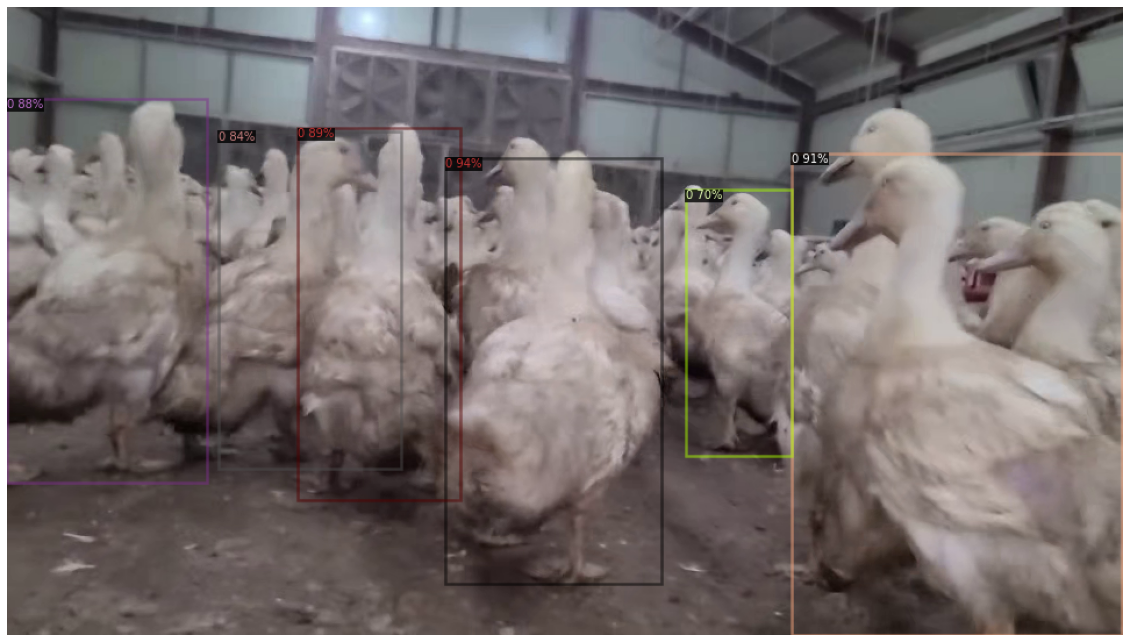

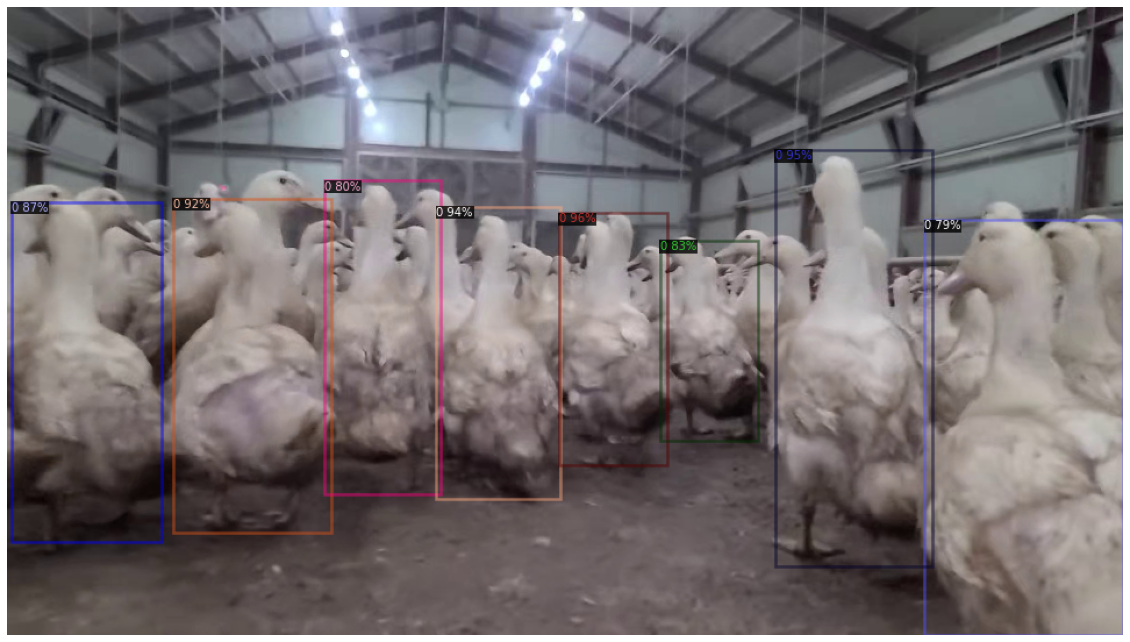

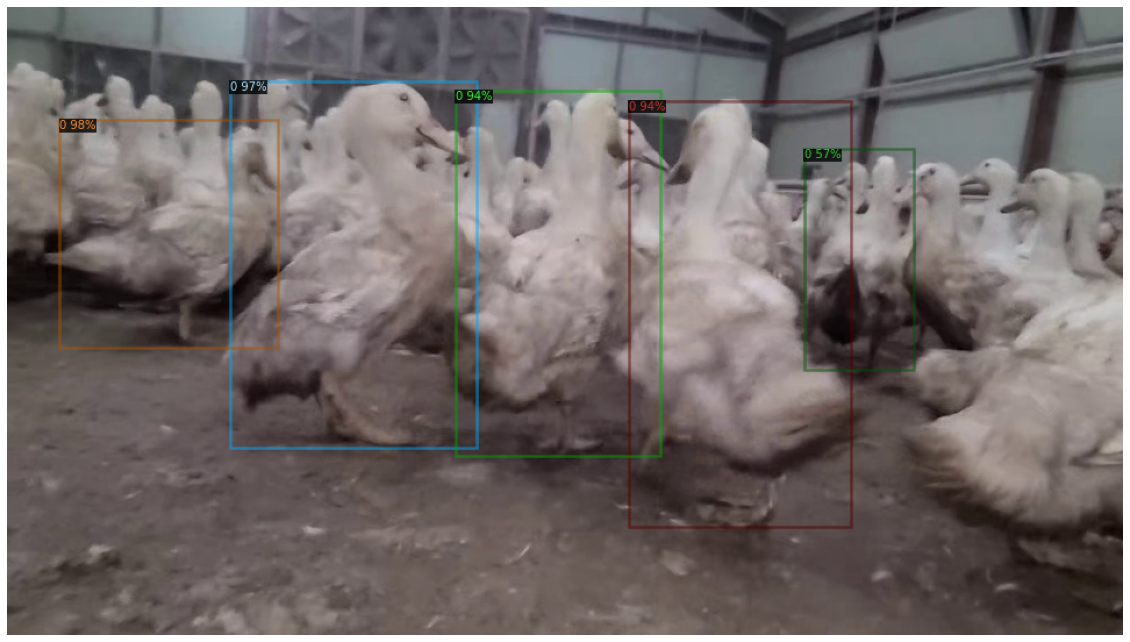

In [26]:
# 인퍼런스
for image_path in random.sample(image_list[-10:],3):
    im = cv2.imread(image_path)
    outputs = predictor(im)  
    #Visualizer 생성 
    v = Visualizer(im[:, :, ::-1], scale=0.5)
    #이미지 상에 예측한 결과들을 인스턴스(물체)별로 그리기 
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #이미지 화면에 출력 
    imshow(out.get_image()[:, :, ::-1])

In [27]:

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#COCOEvaluator : 여러 task들에 대해 AP(Average Precision)을 측정할 수 있음 
#데이터셋 이름, 측정할 task 종류들, False(현재 과정의 결과들만을 측정), dataset에서 예측된 모든 결과들을 저장할 경로)
evaluator = COCOEvaluator("duck_train", ("bbox",), False, output_dir="./output/")
#테스트 셋으로 구성된 test loader 생성 
val_loader = build_detection_test_loader(cfg, "duck_train")
#테스트 셋으로 모델 성능 측정 
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [01/14 09:20:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 09:20:30 d2.data.datasets.coco]: Loaded 593 images in COCO format from dataset/labels_train.json
[01/14 09:20:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/14 09:20:30 d2.data.common]: Serializing 593 elements to byte tensors and concatenating them all ...
[01/14 09:20:30 d2.data.common]: Serialized dataset takes 0.36 MiB
[01/14 09:20:30 d2.evaluation.evaluator]: Start inference on 593 batches
[01/14 09:20:31 d2.evaluation.evaluator]: Inference done 11/593. Dataloading: 0.0006 s/iter. Inference: 0.0362 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:21
[01/14 09:20:36 d2.evaluation.evaluator]: Inference done 149/593. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/ite

In [28]:

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#COCOEvaluator : 여러 task들에 대해 AP(Average Precision)을 측정할 수 있음 
#데이터셋 이름, 측정할 task 종류들, False(현재 과정의 결과들만을 측정), dataset에서 예측된 모든 결과들을 저장할 경로)
evaluator = COCOEvaluator("duck_test", ("bbox",), False, output_dir="./output/")
#테스트 셋으로 구성된 test loader 생성 
val_loader = build_detection_test_loader(cfg, "duck_test")
#테스트 셋으로 모델 성능 측정 
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [01/14 09:21:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 09:21:10 d2.data.datasets.coco]: Loaded 10 images in COCO format from dataset/labels_test.json
[01/14 09:21:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/14 09:21:10 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[01/14 09:21:10 d2.data.common]: Serialized dataset takes 0.00 MiB
[01/14 09:21:10 d2.evaluation.evaluator]: Start inference on 10 batches
[01/14 09:21:11 d2.evaluation.evaluator]: Total inference time: 0:00:00.261286 (0.052257 s / iter per device, on 1 devices)
[01/14 09:21:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.034072 s / iter per device, on 1 devices)
[01/14 09:21:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ..